# Lab 4 - Internal Representation of Numbers & its Effects on Algorithms
-------------------
# Contents
- Introduction to numerical representation
    - Integers - signed, unsigned
    - Floating-points - 32-bit, 64-bit
- Floating point (FP) arithmetic - issues and limitations
    - Representation error
    - Aliasing error
    - Type casting error
    - Overflow error
    - Roundoff error
- Effects of FP datatypes on 2D convolution results
    - Run-time
    - Memory usage over time
    - Precision of result
------------------

In this tutorial, we will look at how different datatypes can have an impact on the computation efficiency in terms of both time and memory. Furthermore, we will see what's the cost we pay for speed/memory improvements by actively managing datatypes with numpy.

In Python, data is stored in memory in the form of binary bits. Interestingly, the same set of bits can mean different values when interpreted as different data types. Being a high-level programming language, Python keeps these tedious calculations behind the curtain most of the time. However, datatype is still an important aspect when it comes to numerical calculations.

### Integers

**10110101**

Unsigned integer: 181

Signed integer: -75

In [1]:
bit_string = "10110101"
x = int(bit_string, 2)
print("decimal: ", x)

decimal:  181


In [2]:
(2**7) + (2**5) + (2**4) + (2**2) + (2**0)

181

In [3]:
import numpy as np

signed_int = np.int8(x) # signed
unsigned_int = np.uint8(x) # unsigned

print("signed: ", signed_int)
print("unsigned: ", unsigned_int)

signed:  -75
unsigned:  181


In [4]:
-(2**7) + (2**5) + (2**4) + (2**2) + (2**0)

-75

Read more - https://cheever.domains.swarthmore.edu/Ref/BinaryMath/NumSys.html

### Floating points

![](fp_representation.jpg)

IEEE-754 converter: [https://www.h-schmidt.net/FloatConverter/IEEE754.html](https://www.h-schmidt.net/FloatConverter/IEEE754.html)

Watch [this video](https://www.youtube.com/watch?v=RuKkePyo9zk) (21:34) to see how "decimal points" work in computer memory.

Numpy's floating point datatypes comforms to IEEE-754 floating point standard, and match the underlying C language data types:

|Numpy Type | C Type|
|---|----|
|np.float32 |	float|
|np.float64 |	double|
|np.float96 |	long double|
|np.float128 | long double|

**[Exercise] What's an advantage of using a 64-bit float as compared to 32-bit? What's an disadvantage?**

Read about [extended precision floating point types in Numpy](https://numpy.org/devdocs/user/basics.types.html#extended-precision)

*Your answer:*

---------------------------------
64-bit adds more precision to data; however, it takes up more space compared to 32-bit

### Representation error

Representation error refers to the fact that some (most, actually) decimal fractions cannot be represented exactly as binary (base 2) fractions.

In [5]:
.1 + .1 + .1 == .3

False

Why is that? 1/10 is not exactly representable as a binary fraction. Almost all platforms map Python floats to IEEE-754 “double precision”. **754 doubles contain 53 bits of precision, so the computer strives to convert 0.1 to the closest fraction it can of the form J / 2\*\*N where J is an integer containing exactly 53 bits.**

i.e. 1/10 ~= J / 2\*\*N.

Let's try to find J and N on our own.

In [6]:
N = 56

2**52 <=  2**N // 10  < 2**53

True

That is, 56 is the only value for N that leaves J with exactly 53 bits. The best possible value for J is then that quotient rounded:

In [7]:
q, r = divmod(2**56, 10)
print(q)
print(r)

7205759403792793
6


Since remainder is closer to 10, round up q by 1.

In [8]:
J = q + 1
J

7205759403792794

In [9]:
two_power_N = 2 ** 56
two_power_N

72057594037927936

Therefore best possible approximation of 1/10 is:

In [10]:
format(J / two_power_N, '.55f')

'0.1000000000000000055511151231257827021181583404541015625'

This is exactly the decimal value that is being represented internally. Let's confirm our calculation:

In [11]:
from decimal import Decimal
Decimal.from_float(0.1)

Decimal('0.1000000000000000055511151231257827021181583404541015625')

In [12]:
bin_str = "{0:b}".format(7205759403792794) # J
print (bin_str)
len(bin_str)

11001100110011001100110011001100110011001100110011010


53

We can get `J` and `two_power_N` more easily:

In [13]:
from fractions import Fraction

print(Fraction.from_float(0.1))
print((0.1).as_integer_ratio())

# 7205759403792794 / 2 ** 56 --> divide by 2 --> 3602879701896397 / 2 ** 55

3602879701896397/36028797018963968
(3602879701896397, 36028797018963968)


These are the same `J` (numerator) and `two_power_N` (denominator) values we found before, but both divided by 2.

### [Exercise] What integer fraction does 3.14159 actually equal to?

In [14]:
x = 3.14159

In [18]:
# assert x == ??? / ???
print(Fraction.from_float(x))
y = Fraction.from_float(x)
assert x == y

3537115888337719/1125899906842624


### Aliasing errors

In [21]:
import numpy as np
val = np.float32(0.1)
print(val.dtype)
format(val, '.55f')

float32


'0.1000000014901161193847656250000000000000000000000000000'

In [22]:
format(np.float64(val), '.55f')

'0.1000000014901161193847656250000000000000000000000000000'

We expect the representational error of a double to be smaller than that of a float. However, casting the float to a double has the effect of persisting the representational error of the float since enough 0’s are added to the right of the significand value to pad out the significand of a double.

### Type casting errors

In [23]:
arr = np.array([3.2, -1.0, 6.8, 10.12])
print(arr, arr.dtype)

[ 3.2  -1.    6.8  10.12] float64


In [24]:
arr.astype(np.int32)

array([ 3, -1,  6, 10], dtype=int32)

### Overflow error

In [25]:
np.power(100, 8, dtype=np.int64)

10000000000000000

In [26]:
np.power(100, 8, dtype=np.int32)

1874919424

In [27]:
print(np.iinfo(np.int32))
print(np.iinfo(np.int64))

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



### Roundoff Error

When two floating point numbers are operated on, their representation is adjusted such that their exponents match the higher value of the two. This also requires the significand to be adjusted such that the original value is still represented. 

When two floating point numbers are operated on, their representation is adjusted such that their exponents match the higher value of the two. This also requires the significand to be adjusted such that the original value is still represented. When this occurs, since the exponent of the floating point is usually increase, the significand gets right shifted. **The problem arises is when the significand starts to loose bits of the right side due to the limited number of bits in the significand. This causes the significant digits of the significand to be reduced and the value represented rounded off as a result, hence the reason it is called round off error.**

In [28]:
import numpy as np
values = np.full(shape=100, fill_value=10, dtype=np.float32) # Return a new array of given shape and type, filled with fill_value.
sum = np.float32(100000000)
for val in values:
    sum += val

In [29]:
sum

100000800.0

Since we're adding ten 100 times, we expect to see 100001000.0 but `sum` falls short of this result. Let's try to capture this error:

In [30]:
def get_sum(dtype):
    values = np.full(shape=100, fill_value=10, dtype=dtype) # Return a new array of given shape and type, filled with fill_value.
    sum = dtype(100000000)

    for val in values:
        temp_sum = sum + val # sum two components
        error = (temp_sum - sum) - val # from the sum, subtract both components, should get ideally 0 but there will be a non-zero error
        sum = temp_sum # update for next iteration

    return sum, error

In [31]:
f32_sum, f32_error = get_sum(np.float32)
f64_sum, f64_error = get_sum(np.float64)
print(f"f32: {format(f32_sum, '.1f')} {format(f32_error, '.1f')}")
print(f"f64: {format(f64_sum, '.1f')} {format(f64_error, '.1f')}")

f32: 100000800.0 -2.0
f64: 100001000.0 0.0


Read more about how mitigate this error - https://diybigdata.net/2016/07/data-science-and-floating-point-arithmetic/

---------------------------

### Effects of datatypes on 2D convolution results - Run time

We will use the memory profiler library to analyze the memory utilization

In [32]:
!pip install memory_profiler
%load_ext memory_profiler

from skimage.io import imread, imshow, imsave
from skimage.filters import gaussian
from scipy.signal import convolve2d
from skimage.color import rgb2gray
import numpy as np
from matplotlib import pyplot as plt
import time
%matplotlib inline
from memory_profiler import memory_usage

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
def convolve2D(image, kernel, padding=0):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int((xImgShape - xKernShape + 2 * padding) + 1)
    yOutput = int((yImgShape - yKernShape + 2 * padding) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros(
            (image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding),
                    int(padding):int(-1 * padding)] = image
        # print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape + 2*padding:
            break
        # Only Convolve if y has gone down by the specified Strides

        for x in range(image.shape[0]):
            # Go to next row once kernel is out of bounds
            if x > image.shape[0] - xKernShape + 2*padding:
                break
            try:
                # Only Convolve if x has moved by the specified Strides
                output[x, y] = (
                    kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]
                ).sum()
            except:
                break

    return output

We will convolve matrices of floating point number of different precisions using the same convolve2D function, and observe the performance (time and memory utilization) as well as the accuracy

In [38]:
A =  np.random.random_sample(size=(100,100))
B = np.random.random_sample(size=(5,5))

your_result = convolve2D(A, B, padding=2)

print(your_result)
print(your_result.shape)

np.allclose(your_result, convolve2d(A, B, mode="same"))

[[2.67594646 2.165517   4.45517595 ... 3.93057665 3.10975869 2.37155913]
 [3.53748502 4.25326013 6.58503119 ... 5.13068477 4.89668476 3.89007487]
 [4.92358565 5.39072863 6.61962829 ... 6.61710741 5.22815145 3.8626043 ]
 ...
 [4.39949625 5.6243722  6.58515959 ... 8.36863296 5.55975376 4.58690923]
 [3.42089864 4.08054965 6.4205223  ... 6.18626252 4.35591681 4.00938626]
 [2.28375659 3.66778002 5.19553999 ... 4.56410854 3.72885403 3.42049227]]
(100, 100)


True

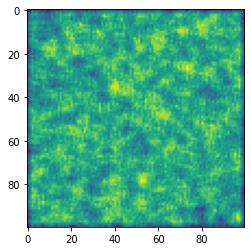

In [39]:
plt.imshow(your_result)
#plt.imshow(convolve2d(A, B, mode='same'))

In [40]:
def test_conv(datatype):
    start_time = time.time()
    print("--- Testing {} ---".format(datatype))
    for _ in range(5):

        A =  np.random.random_sample(size=(1000, 500)).astype(datatype)
        B = np.random.random_sample(size=(10,10)).astype(datatype)

        your_result = convolve2D(A, B, padding=2)

    print("--- Done: The execution took %s seconds ---" %
          (time.time() - start_time))

In the cell below, we use the function "memory_usage" to measure the memory utilization during the execution of the chosen function. At the same time, we record the runtime of each trial.

In [41]:
float_types = ["float16", "float32", "float64", "float128"]

memory_utilization_tracker = []
for float_type in float_types:
    mem_usage = memory_usage((test_conv, (float_type,), ), timestamps=False, interval=1)
    memory_utilization_tracker.append(mem_usage)

--- Testing float16 ---
--- Done: The execution took 22.63413166999817 seconds ---
--- Testing float32 ---
--- Done: The execution took 21.607362270355225 seconds ---
--- Testing float64 ---
--- Done: The execution took 21.279563188552856 seconds ---
--- Testing float128 ---
--- Done: The execution took 25.478107213974 seconds ---


**Q: What do you notice about the run time among the trials? Does the result match your expectations?**

*your answer:*

I noticed that lower precision doesn't equate to lower execution time; however, when float128 is being executed, there is an increase in execution time. For float16,32,64, they have similar times because python is implicitly using 64-bit processing. float128 has higher execution time because the innate 64-bit processor must perform increased computation since 128 > 64.


### Effects of datatypes on 2D convolution results - Memory usage

Now let's compare the memory utilization over time using plots:

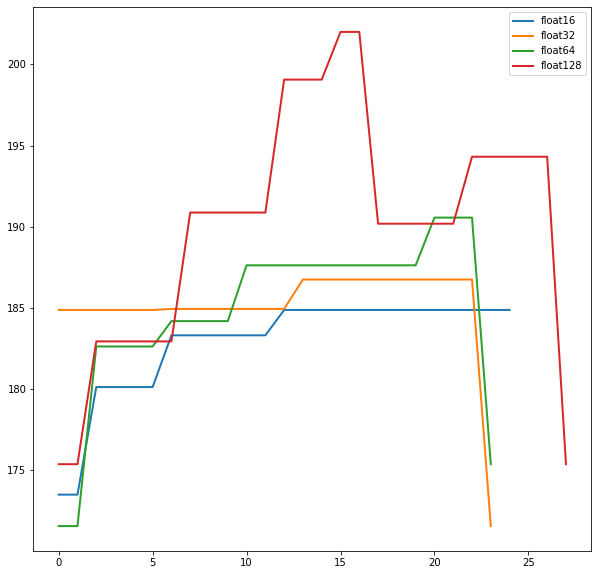

In [43]:
plt.figure(figsize=(10,10))

for mem_usage, data_type in zip(memory_utilization_tracker, float_types):
    plt.plot(list(range(len(mem_usage))), mem_usage, label=data_type, linewidth=2)
    
plt.legend()
plt.show()    

**Q: What do you notice? Can you explain the difference in the memory usage?**

*your answer:*

As float size increases, there is increase in memory usage; there is a minimal residual between 16,32,64 bits due to the innate 64-bit processing that is occurring; however, float128 has higher memory compared to the other counterparts, which can be explained by the 64-bit computation.

### Effects of datatypes on 2D convolution results - Precision of result

We gained (low) memory usage and (high) speed when using lower precision (16/32/64 vs. 128), what did we lose? Correctness of the solution.

Let's see how different the solutions with different datatypes are:

In [44]:
A_128 =  np.random.random_sample(size=(500,500)).astype("float128")
B_128 = np.random.random_sample(size=(10,10)).astype("float128")
A_64 =  A_128.astype("float64")
B_64 = B_128.astype("float64")
A_32 =  A_128.astype("float32")
B_32 = B_128.astype("float32")
A_16 =  A_128.astype("float16")
B_16 = B_128.astype("float16")

result_128 = convolve2D(A_128, B_128, padding=2)
result_64 = convolve2D(A_64, B_64, padding=2)
result_32 = convolve2D(A_32, B_32, padding=2)
result_16 = convolve2D(A_16, B_16, padding=2)

Finally, let's see the cost of the efficiency gain by using lower-precision data types. We will do this by comparing the result of lower-precision datatypes to that of the highest precision datatype.

In [45]:
print((np.abs(result_128 - result_64)).sum())
print((np.abs(result_128 - result_32)).sum())
print((np.abs(result_128 - result_16)).sum())

4.941362874433253e-10
0.01617054365213555
135.36633476525458


**Q: What do you notice? Can you explain what you see?**

*your answer:*

The result_128 is assumed to be the most precise floating point representation, whereas 64,32,16 sized floats are decreasingly precise. It can be seen that as float size representation decreases, there is a propagation/increase in error. As floating point size decreases there is exponentially increasing residual.


---------------
# References
- https://docs.python.org/3/tutorial/floatingpoint.html
- https://diybigdata.net/2016/07/data-science-and-floating-point-arithmetic/
- https://www.lahey.com/float.htm
- https://numpy.org/doc/stable/user/basics.types.html
- https://numpy.org/doc/stable/reference/arrays.scalars.html#integer-types